In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
# LSTM Model
class Seq2Scalar(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Seq2Scalar, self).__init__()
        
        # LSTM
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        
        # Regularization
        self.bn = nn.BatchNorm1d(num_features=hidden_size)
        self.dropout = nn.Dropout(p=0.25)
        
        # Feed Forward Layer
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.PReLU()
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros((self.num_layers * 2, batch_size, self.hidden_size), device=device, requires_grad=True)
        c0 = torch.zeros((self.num_layers * 2, batch_size, self.hidden_size), device=device, requires_grad=True)
        out, (hn, cn) = self.lstm(x.view(batch_size, 1, -1), (h0, c0))

        out = self.activation(self.linear1(self.bn(hn[0])))
        out = self.dropout(out)
        out = self.linear2(out)
        
        return out

In [4]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, data):
        
        # Inputs
        self.x = data[:, :-1]
        
        # Output
        self.y = data[:, -1]
        
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        
        # Inputs
        inp = self.x[idx]
        inp = inp.flatten()
        
        # Outputs
        out = self.y[idx]
        out = out.flatten()
        
        return torch.tensor(inp).float(), torch.tensor(out).float()

# Load the dataset
train_data = np.load("./Dataset/train_no_pos.npy")
val_data = np.load("./Dataset/val_no_pos.npy")
test_data = np.load("./Dataset/test_no_pos.npy")

# Using PyTorch Dataloader
train_dataset = TrajDataset(train_data)
val_dataset = TrajDataset(val_data)
test_dataset = TrajDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

In [5]:
for batch_num, (datas) in enumerate(train_loader):
    inp, out = datas
    print(inp.shape, out.shape)
    break

torch.Size([256, 18]) torch.Size([256, 1])


In [6]:
# LSTM Inputs
input_size = 18
hidden_size = 256
num_layers = 24
output_size = 1

epochs = 150
model = Seq2Scalar(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = optim.AdamW(model.parameters(), lr = 6e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)
criterion = nn.MSELoss()

avg_train_loss, avg_val_loss = [], []
for epoch in range(epochs):

    # Train Loop
    losses_train = []
    model.train()
    for inp, out in train_loader:

        inp = inp.to(device)
        out = out.to(device)

        # Forward Pass
        pred = model(inp)
        loss = criterion(pred, out)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach().cpu().numpy())

    # Test Loop
    losses_val = []
    model.eval()
    for inp, out in val_loader:

        inp = inp.to(device)
        out = out.to(device)

        # No Gradients
        with torch.no_grad():
            pred = model(inp)
            test_loss = criterion(pred, out)

        losses_val.append(test_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f},  Val Loss: {np.average(losses_val):.3f}")

    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_val_loss.append(np.average(losses_val))

Epoch: 1, Train Loss: 0.050,  Val Loss: 0.055
Epoch: 2, Train Loss: 0.041,  Val Loss: 0.054
Epoch: 3, Train Loss: 0.029,  Val Loss: 0.054
Epoch: 4, Train Loss: 0.028,  Val Loss: 0.050
Epoch: 5, Train Loss: 0.027,  Val Loss: 0.038
Epoch: 6, Train Loss: 0.026,  Val Loss: 0.024
Epoch: 7, Train Loss: 0.024,  Val Loss: 0.029
Epoch: 8, Train Loss: 0.022,  Val Loss: 0.023
Epoch: 9, Train Loss: 0.022,  Val Loss: 0.024
Epoch: 10, Train Loss: 0.022,  Val Loss: 0.024
Epoch: 11, Train Loss: 0.022,  Val Loss: 0.021
Epoch: 12, Train Loss: 0.021,  Val Loss: 0.023
Epoch: 13, Train Loss: 0.021,  Val Loss: 0.022
Epoch: 14, Train Loss: 0.020,  Val Loss: 0.022
Epoch: 15, Train Loss: 0.020,  Val Loss: 0.023
Epoch: 16, Train Loss: 0.020,  Val Loss: 0.021
Epoch: 17, Train Loss: 0.019,  Val Loss: 0.020
Epoch: 18, Train Loss: 0.019,  Val Loss: 0.020
Epoch: 19, Train Loss: 0.019,  Val Loss: 0.020
Epoch: 20, Train Loss: 0.019,  Val Loss: 0.021
Epoch: 21, Train Loss: 0.019,  Val Loss: 0.020
Epoch: 22, Train Loss:

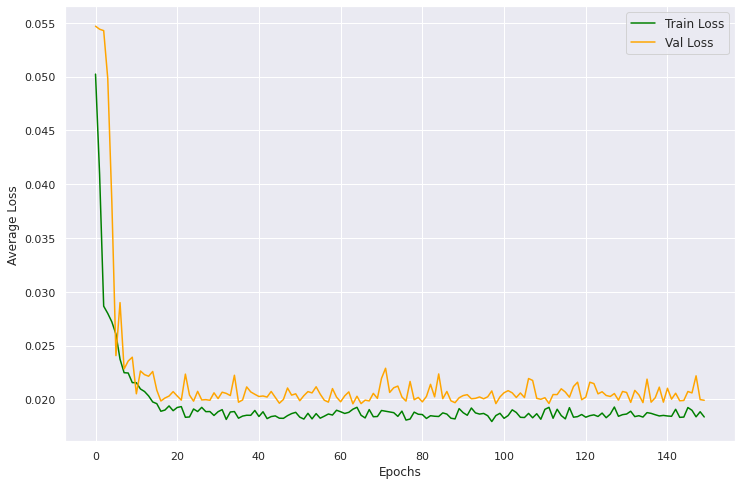

In [7]:
e = np.arange(epoch+1)

plt.figure( figsize=(12, 8))
plt.plot(e, np.array(avg_train_loss), label="Train Loss", color="green")
plt.plot(e, np.array(avg_val_loss), label="Val Loss", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
# plt.ylim([0, 30])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()

In [11]:
torch.save(model.state_dict(), './new_weights_no_pos.pth')

In [8]:
# Load the Test Dataset
test_set = torch.from_numpy(test_data)

# Feature and Ground Truth Matrix
X = test_set[:, :-1].to(device)
y = test_set[:, -1].reshape(-1, 1).to(device)

# Inference
with torch.no_grad():
    model.eval()
    test_pred = model(X)

test_loss = criterion(test_pred, y)    

print(f"Test MSE Loss: {test_loss:.3f}")

test_set.shape, X.shape, y.shape, test_pred.shape

Test MSE Loss: 0.021


(torch.Size([1222, 19]),
 torch.Size([1222, 18]),
 torch.Size([1222, 1]),
 torch.Size([1222, 1]))

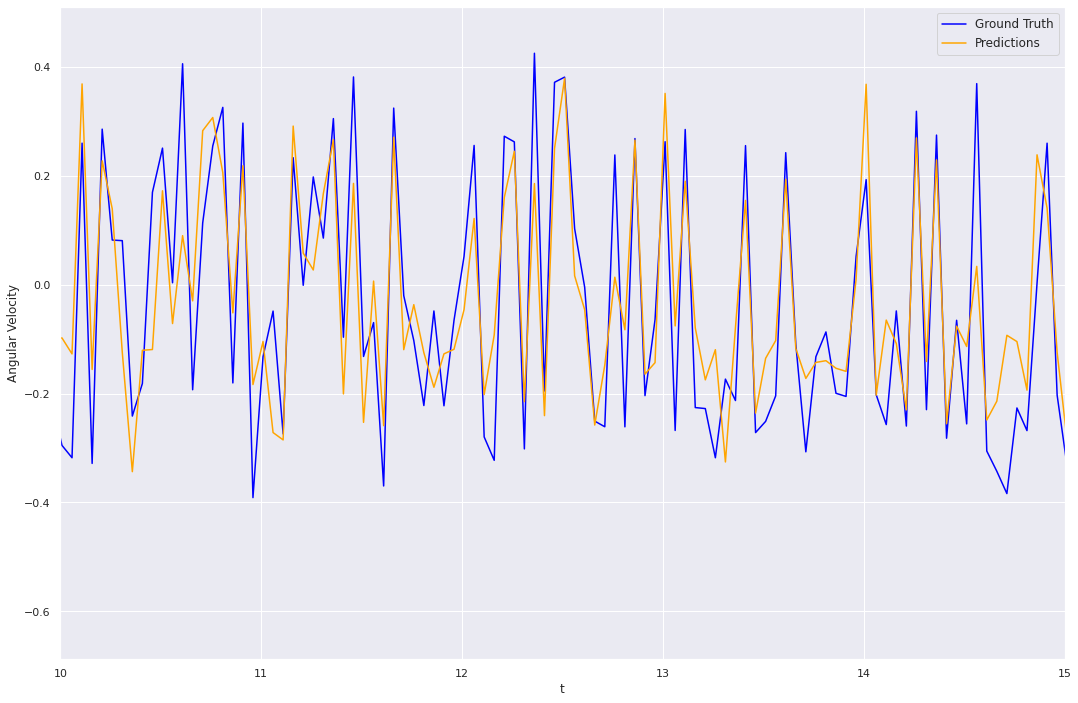

In [10]:
t = np.linspace(0, X.shape[0], X.shape[0])*0.05

%matplotlib inline
plt.figure( figsize=(18, 12))
plt.plot(t, y.cpu().numpy(), label="Ground Truth", color="blue")
plt.plot(t, test_pred.cpu().numpy(), label="Predictions", color="orange")
plt.legend(loc=1 ,prop={'size': 12})
plt.xlim(10, 15)
# plt.ylim(-10, 10)
plt.xlabel("t")
plt.ylabel("Angular Velocity")
# plt.savefig("GRU Predictions.png")
plt.show()